In [4]:
# Tarefa 1
import pandas as pd

# Ler dados
owid_energy_data = pd.read_csv('owid-energy-data.csv')

# Filtrar dados
countries = ['United States', 'Canada', 'Brazil', 'Mexico']
energy_data = owid_energy_data[owid_energy_data['country'].isin(countries)]

# Escrever dados
energy_data.to_csv('filtered-energy-data.csv')

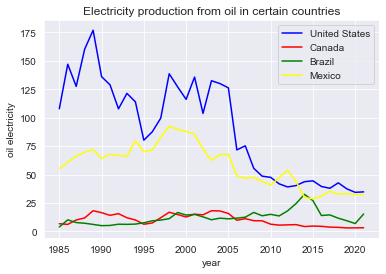

In [55]:
# Tarefa 2
import matplotlib.pyplot as plt

# Criar figura e definir cores
plt.figure()
colors = ['blue', 'red', 'green', 'yellow']

# Plot dos dados de 'oil_electricity', para cada país
for country, color in zip(countries, colors):
    data = energy_data[(energy_data.country == country)
                       & (energy_data['oil_electricity'].notnull())]
    plt.plot(data.year, data['oil_electricity'], '-', color=color, label=country)

# Customizar figura
plt.xlabel('year')
plt.ylabel('oil electricity')
plt.title('Electricity production from oil in certain countries')
plt.legend()
plt.show()

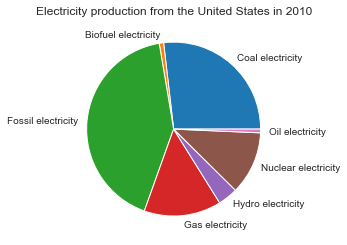

In [54]:
# Tarefa 3
# Dados dos Estados Unidos em 2010
usa_energy_data = energy_data[(energy_data.country == 'United States')
                              & (energy_data.year == 2010)]

# Filtrar segundo fontes de eletricidade
elec_sources = ['coal_electricity', 'biofuel_electricity',
                'fossil_electricity', 'gas_electricity',
                'hydro_electricity', 'nuclear_electricity',
                'oil_electricity']
usa_electricity = usa_energy_data[elec_sources].values.flatten().tolist()

# Plot dos dados num gráfico circular
plt.figure()
plt.title('Electricity production from the United States in 2010')
elec_sources = [s.replace('_', ' ').capitalize() for s in elec_sources]
plt.pie(usa_electricity, labels=elec_sources)
plt.show()

In [5]:
# Tarefa 4
import numpy as np

# Determinar ano e valor de maior consumo de energia nuclear
def highest_nuclear_consumption(country: str) -> np.float64:
    country_data: pd.DataFrame = energy_data.loc[(energy_data.country == country),
                                                 ['year', 'nuclear_consumption']]
    i = country_data['nuclear_consumption'].idxmax()
    year = country_data.loc[i, 'year']
    consumption = country_data.loc[i, 'nuclear_consumption']
    print(f'Nuclear consumption of {country} in {year} was {consumption}')
    return consumption

# Exemplos para lista de países
print('Highest nuclear consumption year per country:')
[highest_nuclear_consumption(country) for country in countries]

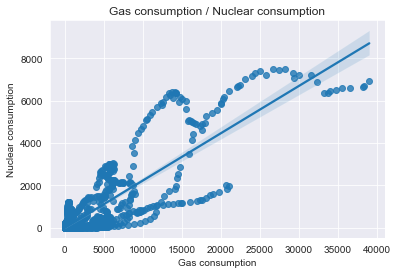

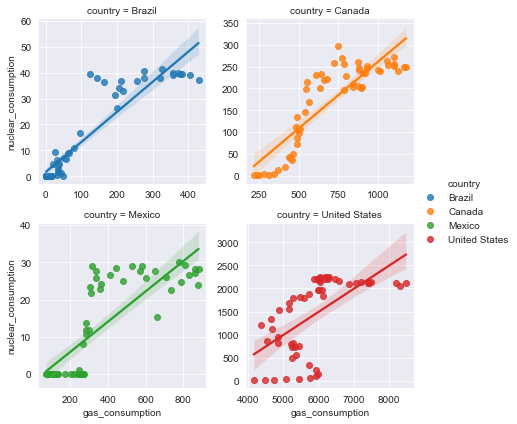

In [53]:
# Tarefa 5
import seaborn as sns

# Plot de dispersão geral
sns.regplot(data=owid_energy_data, x='gas_consumption', y='nuclear_consumption')
plt.xlabel('Gas consumption')
plt.ylabel('Nuclear consumption')
plt.title(f'Gas consumption / Nuclear consumption')

# Plot de dispersão para cada país
grid = sns.FacetGrid(energy_data, col="country", hue="country", col_wrap=2,
                     sharex=False, sharey=False)
grid.map(sns.regplot, 'gas_consumption', 'nuclear_consumption')
grid.add_legend()
plt.show()

R² = 0.9840113626006891
Y = 2.787e-04 * e^(-0.256 * x) + -1.84


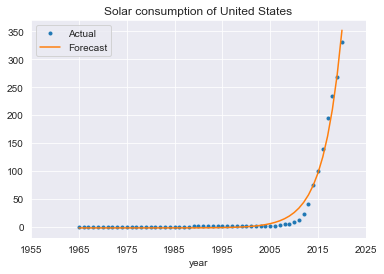

Forecast for 2021: 454.650


In [52]:
# Tarefa 6 - Usando um algoritmo de ajuste de curva
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Exponential function with generic parameters
def mono_exp(x, m, t, b):
    return m * np.exp(t * x) + b

# Solar consumption data for the United States
solar_data: pd.DataFrame = energy_data.loc[
    (energy_data.country == 'United States') & (energy_data.solar_consumption.notnull()),
    ['year', 'solar_consumption']]

# Training data, xs is adjusted for better optimization
xs = solar_data['year'].to_numpy()
ys = solar_data['solar_consumption'].to_numpy()
xs_shifted = xs - xs[0]

# perform the fit
p0 = (1, 1e-6, 0)  # start with values near those we expect
params, cv = opt.curve_fit(mono_exp, xs_shifted, ys, p0)
m, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - mono_exp(xs_shifted, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f'R² = {rSquared}')
print(f'Y = {m:.3e} * e^(-{t:.3} * x) + {b:.3}')

# plot the results
plt.plot(xs_shifted, ys, '.', label='data')
plt.plot(xs_shifted, mono_exp(xs_shifted, m, t, b), '-', label='fitted')
plt.title(f'Solar consumption of {countries[0]}')
xlocs, _ = plt.xticks()
plt.xticks(xlocs, xlocs.astype(int) + xs[0])
plt.xlabel('year')
plt.legend(['Actual', 'Forecast'])
plt.show()

# Next year forecast
next_year = xs[-1] + 1
print(f'Forecast for {next_year}: {mono_exp(next_year - xs[0], m, t, b):.3f}')

In [2]:
# Tarefa 6 - Usando um modelo LSTM
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [50]:
# United States solar data
solar_data: pd.DataFrame = energy_data.loc[
    (energy_data.country == countries[0]) & (energy_data.solar_consumption.notnull()),
    ['year', 'solar_consumption']]
solar_data.set_index('year', inplace=True)
y = solar_data['solar_consumption'].fillna(method='ffill')
y = y.to_numpy().reshape(-1, 1)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)
# generate the input and output sequences
n_lookback = 10  # length of input sequences (lookback period)
n_forecast = 1  # length of output sequences (forecast period)
X = []
Y = []
for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

In [46]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=50)
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0627
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0585
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0547
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.0514
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0484
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0460
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0441
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0427
Epoch 9/100
1/1 [==============================] - 0s 0s/step - loss: 0.0417
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0407
Epoch 11/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0395
Epoch 12/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0378
Epoch 13/100
1/1 [==============================] - 0s 

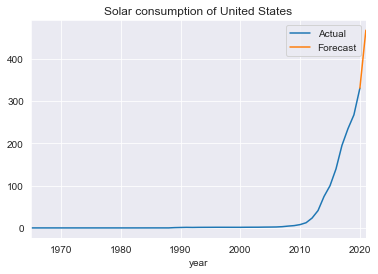

Forecast for 2021: 467.384


In [51]:
# organize the results in a data frame
df_past = solar_data[['solar_consumption']].reset_index()
df_past.rename(columns={'index': 'year', 'solar_consumption': 'Actual'}, inplace=True)
df_past['year'] = pd.date_range(start=str(solar_data.index[0]),
                                periods=len(solar_data), freq='AS')
df_past['Forecast'] = np.nan
df_past.at[df_past.index[-1], 'Forecast'] = df_past.at[df_past.index[-1], 'Actual']

df_future = pd.DataFrame(columns=['year', 'Actual', 'Forecast'])
df_future['year'] = pd.date_range(start=df_past.at[df_past.index[-1], 'year'] + pd.DateOffset(months=12),
                                  periods=n_forecast, freq='AS')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan
results = pd.concat([df_past, df_future]).set_index('year')
# plot the results
results.plot(title=f'Solar consumption of {countries[0]}')
plt.show()
# Prediction for next year
print(f'Forecast for {results.index[-1].year}: {results.at[results.index[-1], "Forecast"]:.3f}')